### HOUSE PRICING

In [77]:
##DATA DESCRIPTION
myfile = open("./house-prices-data/data_description.txt")
txt = myfile.read()
print(txt)

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [78]:
#libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date
pd.options.mode.chained_assignment = None
import h2o
from scipy.special import expit


import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [79]:
train = pd.read_csv('./house-prices-data/train.csv') 
test = pd.read_csv('./house-prices-data/test.csv')

In [80]:
## DATA CLEANING AND FEATURE ENGINEERING

In [81]:
# Drop the id column from both test and training data
train.drop(['Id'],axis=1, inplace=True)
test.drop(['Id'],axis=1, inplace=True)

In [82]:
print('The shape of train data is {}'.format(train.shape))
print('The shape of test data is {}'.format(test.shape))

The shape of train data is (1460, 80)
The shape of test data is (1459, 79)


In [83]:
#concat both the datasets for easier cleaning 
full = train.append(test, ignore_index=True)

In [84]:
print('The shape of full data is {}'.format(full.shape))

The shape of full data is (2919, 80)


In [85]:
full.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


### Cleaning Data Set


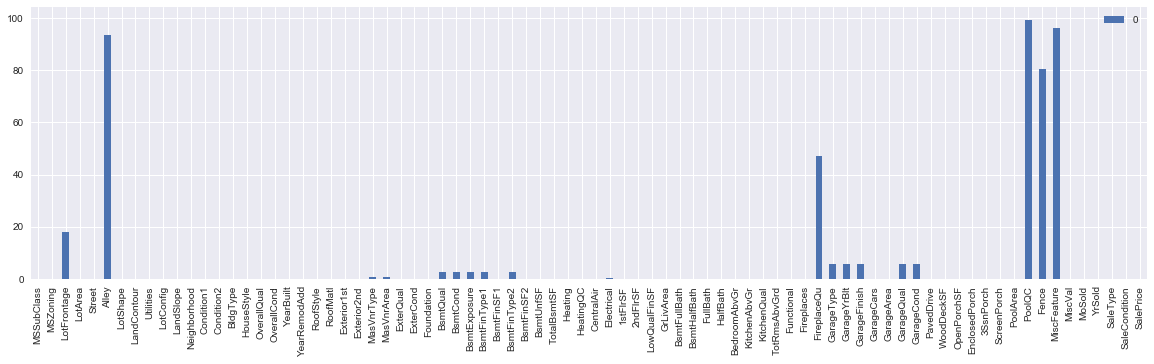

In [86]:
pd.DataFrame(train.isna().sum()*100/train.shape[0]).plot.bar(figsize=(20,5))

* the above plot gives us a summary as percent values for all the variables in the training dataset. 
* For the variables with huge proportion of missing value: Alley, PoolQC, Fence and MiscFeature, it's proper to replace NA value with None. Since None is also a type
* Replaced null values with None in the FireplaceQu column both in test and training set.

In [87]:
## IMPUTING MISSING VALUES

In [88]:
#NA already existing category
full.update(full[['BsmtCond','BsmtFinType2','BsmtFinType1','BsmtExposure','BsmtQual','GarageType','GarageQual','GarageFinish','GarageCond','FireplaceQu','MiscFeature','Fence','PoolQC','Alley']].fillna('NA'))

#none a new category generated
full.update(full[['Electrical','MasVnrType']].fillna('None'))

#nan with zero as constant
full.update(full[['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','BsmtHalfBath','BsmtFullBath','GarageArea','GarageCars','MasVnrArea','TotalBsmtSF']].fillna(0)) #no basement so areas are zero



In [89]:
# Replacing the missing values with medians for the list of variables ['Exterior1st','Exterior2nd','Functional','KitchenQual','MSZoning','SaleType','Utilities']

full['Exterior1st']=full['Exterior1st'].fillna(full.Exterior1st.value_counts().index[0])
full['Exterior2nd']=full['Exterior2nd'].fillna(full.Exterior2nd.value_counts().index[0])
full['Functional']=full['Functional'].fillna(full.Functional.value_counts().index[0])
full['KitchenQual']=full['KitchenQual'].fillna(full.KitchenQual.value_counts().index[0])
full['MSZoning']=full['MSZoning'].fillna(full.MSZoning.value_counts().index[0])
full['SaleType']=full['SaleType'].fillna(full.SaleType.value_counts().index[0])
full['Utilities']=full['Utilities'].fillna(full.Utilities.value_counts().index[0])

#Dropping irrelavent columns from the whole dataset based on the EDA on the training dataset
full= full.drop(['YrSold','MoSold','Condition2','Condition1','MSSubClass','GarageQual','PoolQC','PoolArea','Electrical'],axis=1)

#GarageQual is repetitive - GarageCond
#PoolQC is mostly NA
#Pool Area is mostly 0
#MSSubClass is a combination of Housing.... and year


#### 'PoolQC','PoolArea'

#Test them 3 Cond. 

In [90]:
#filled missing garage years
full['GarageYrBlt'] = full['GarageYrBlt'].fillna(full['YearBuilt'])

In [91]:
#spillitng the data again

train = full[full['SalePrice'].notnull()]
test = full[full['SalePrice'].isnull()]

In [92]:
train_y = train['SalePrice']
train_x = train.drop(['SalePrice'],axis=1)

In [93]:
test_x = test.drop(['SalePrice'],axis=1)

In [94]:
test_x.shape

(1459, 70)

In [95]:
train_x.shape

(1460, 70)

In [96]:
# Get train LotFrontage dummy variables
LotFrontage_Dummies_df = pd.get_dummies(train_x[['LotFrontage', 'MSZoning', 'LotArea', 'LotConfig', 'Neighborhood']])

# Get full dummy variables
# Split the data into LotFrontage known and LotFrontage unknown
LotFrontageKnown = LotFrontage_Dummies_df[LotFrontage_Dummies_df["LotFrontage"].notnull()]
LotFrontageUnknown = LotFrontage_Dummies_df[LotFrontage_Dummies_df["LotFrontage"].isnull()]

# Training data knowing LotFrontage
LotFrontage_Known_X = LotFrontageKnown.drop(["LotFrontage"], axis = 1)
LotFrontage_Known_y = LotFrontageKnown["LotFrontage"]
# Training data unknown LotFrontage
LotFrontage_Unknown_X = LotFrontageUnknown.drop(["LotFrontage"], axis = 1)
# Build model using random forest
from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor(random_state=1,n_estimators=500,n_jobs=-1)
rfr.fit(LotFrontage_Known_X, LotFrontage_Known_y)
rfr.score(LotFrontage_Known_X, LotFrontage_Known_y)

0.9305840449585167

In [97]:
# Predict training data unknown LotFrontage
LotFrontage_Unknown_y = rfr.predict(LotFrontage_Unknown_X)
train_x.loc[train_x["LotFrontage"].isnull(), "LotFrontage"] = LotFrontage_Unknown_y

In [98]:
# Repeat same process for test data
# Get train LotFrontage dummy variables
LotFrontage_Dummies_df = pd.get_dummies(test_x[['LotFrontage', 'MSZoning', 'LotArea', 'LotConfig', 'Neighborhood']])

# Get full dummy variables
# Split the data into LotFrontage known and LotFrontage unknown
LotFrontageKnown = LotFrontage_Dummies_df[LotFrontage_Dummies_df["LotFrontage"].notnull()]
LotFrontageUnknown = LotFrontage_Dummies_df[LotFrontage_Dummies_df["LotFrontage"].isnull()]

# Testing data knowing LotFrontage
LotFrontage_Known_X = LotFrontageKnown.drop(["LotFrontage"], axis = 1)
LotFrontage_Known_y = LotFrontageKnown["LotFrontage"]
# Testing data unknown LotFrontage
LotFrontage_Unknown_X = LotFrontageUnknown.drop(["LotFrontage"], axis = 1)
# Build model using random forest
from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor(random_state=1,n_estimators=500,n_jobs=-1)
rfr.fit(LotFrontage_Known_X, LotFrontage_Known_y)
rfr.score(LotFrontage_Known_X, LotFrontage_Known_y)

0.9456107979297688

In [99]:
# Predict testing data unknown LotFrontage
LotFrontage_Unknown_y = rfr.predict(LotFrontage_Unknown_X)
test_x.loc[test_x["LotFrontage"].isnull(), "LotFrontage"] = LotFrontage_Unknown_y

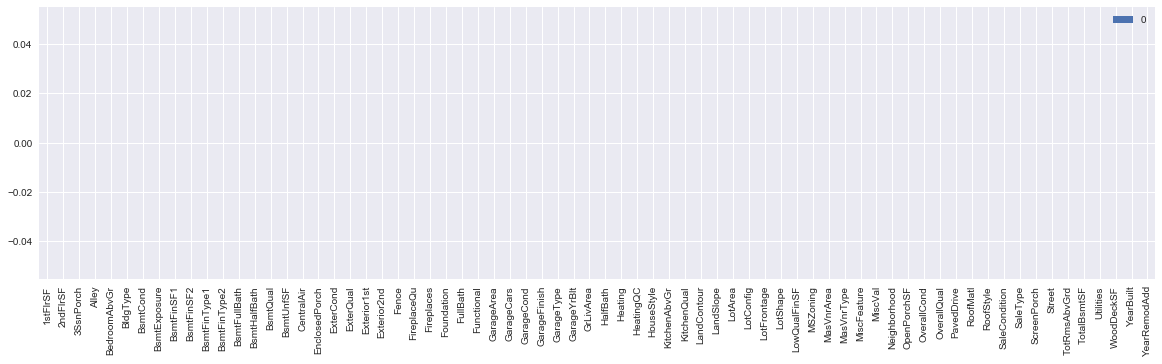

In [100]:
pd.DataFrame(train_x.isna().sum()*100/train_x.shape[0]).plot.bar(figsize=(20,5))

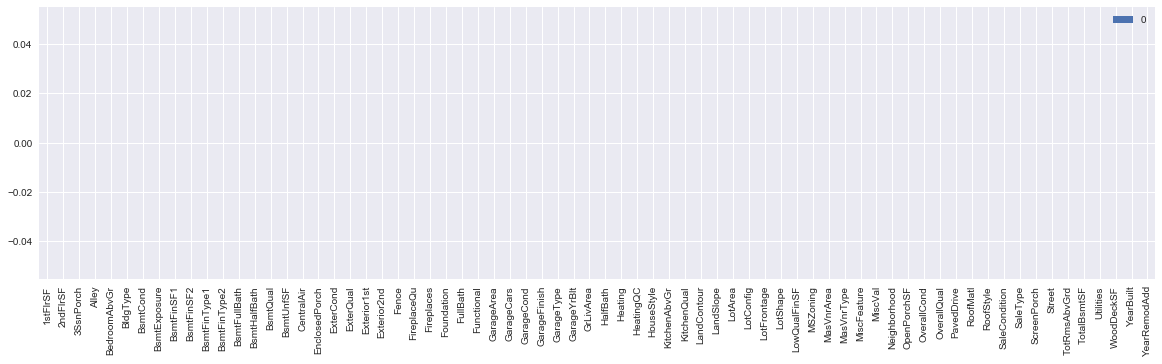

In [101]:
pd.DataFrame(test_x.isna().sum()*100/test_x.shape[0]).plot.bar(figsize=(20,5))

* We can see the data is totally clean and now we can do the feature engineering

In [102]:
train_data = pd.concat([train_y, train_x], axis=1)

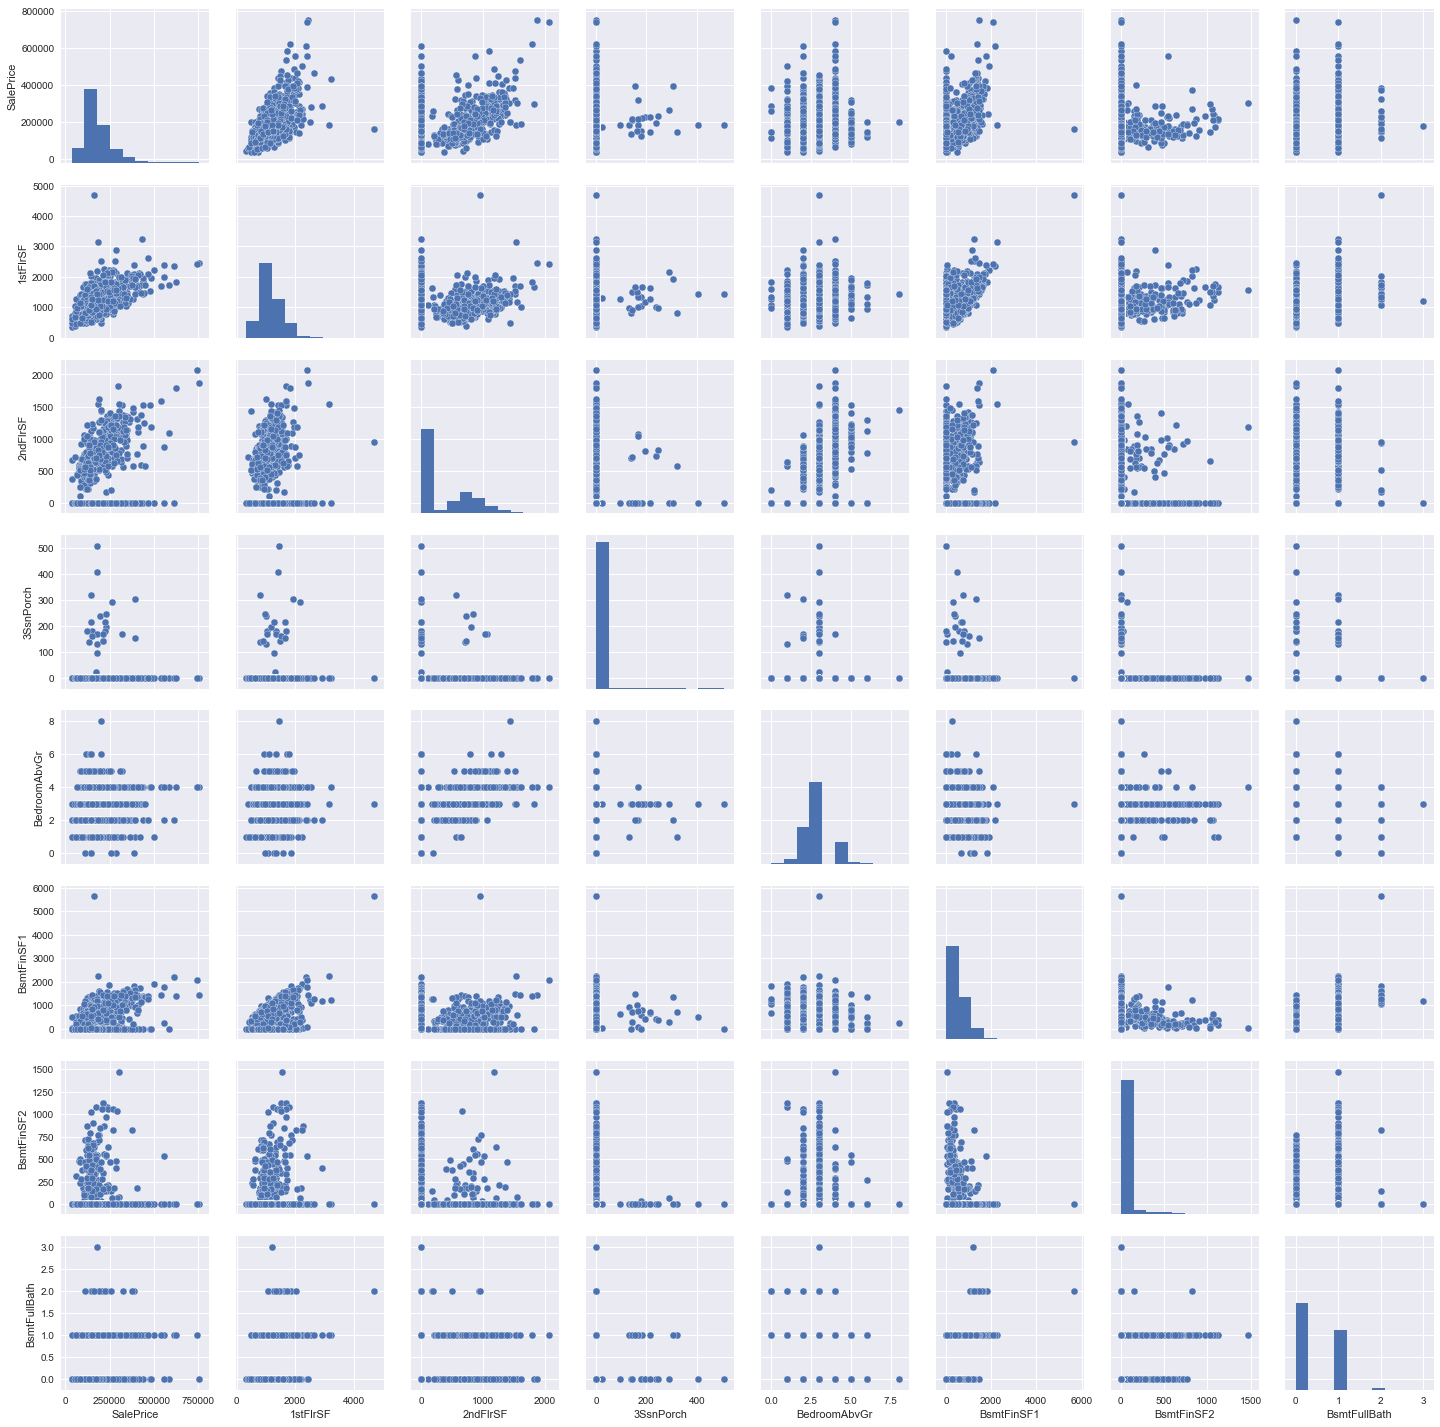

In [103]:
#Using Pair Plot for outlier removal
sns.set()
Continuous = [key for key in dict(train_data.dtypes) if dict(train_data.dtypes)[key] in ['float64', 'int64']]
cols = ['SalePrice',
 '1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath']
sns.pairplot(train_data[cols], size = 2.5)
plt.show();

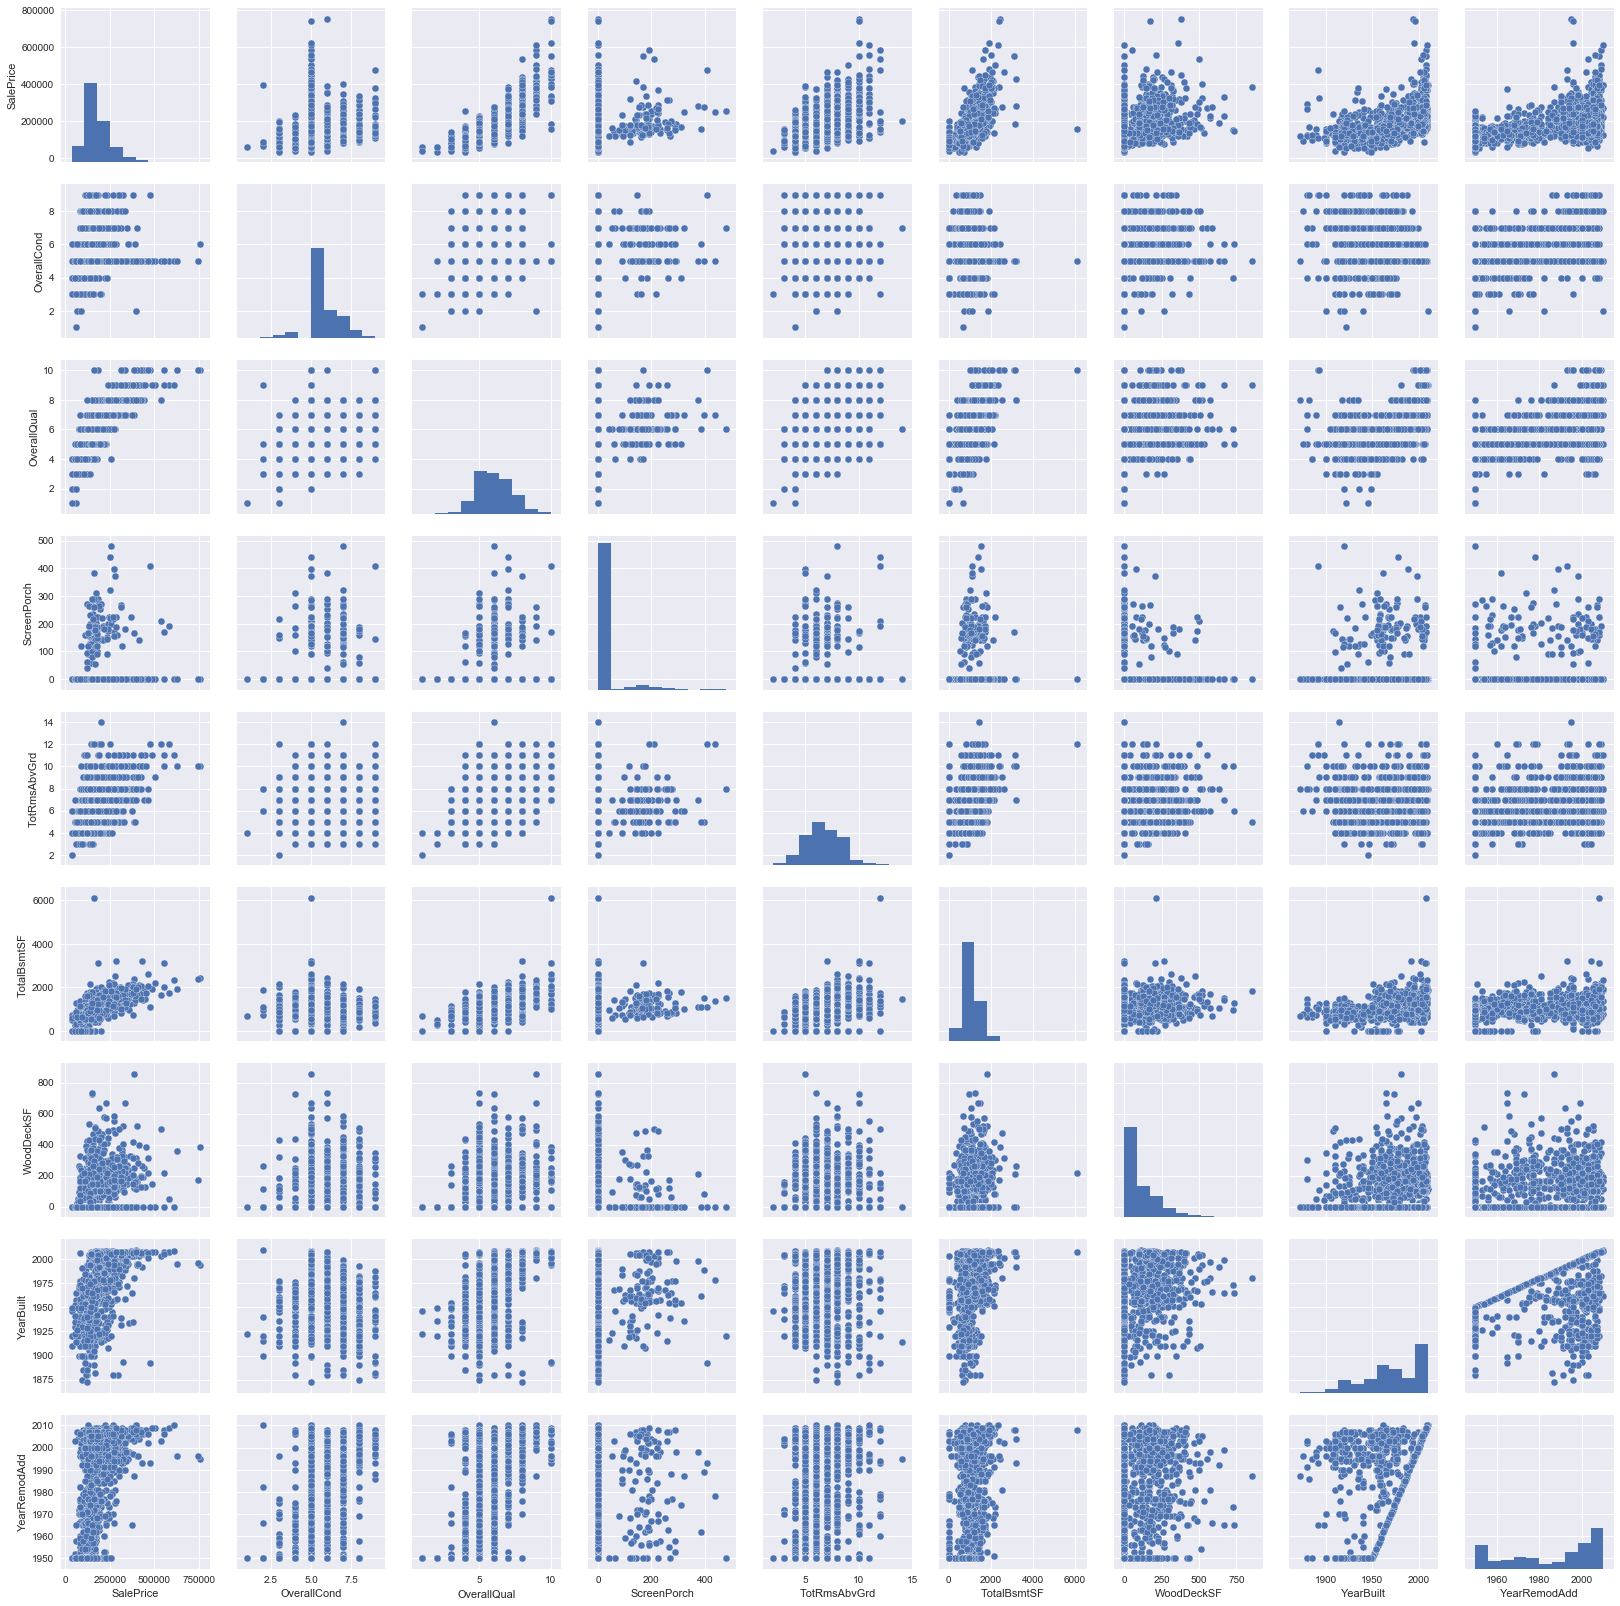

In [104]:
sns.set()
cols = ['SalePrice','OverallCond',
 'OverallQual',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd']
sns.pairplot(train_data[cols], size = 2.5)
plt.show();

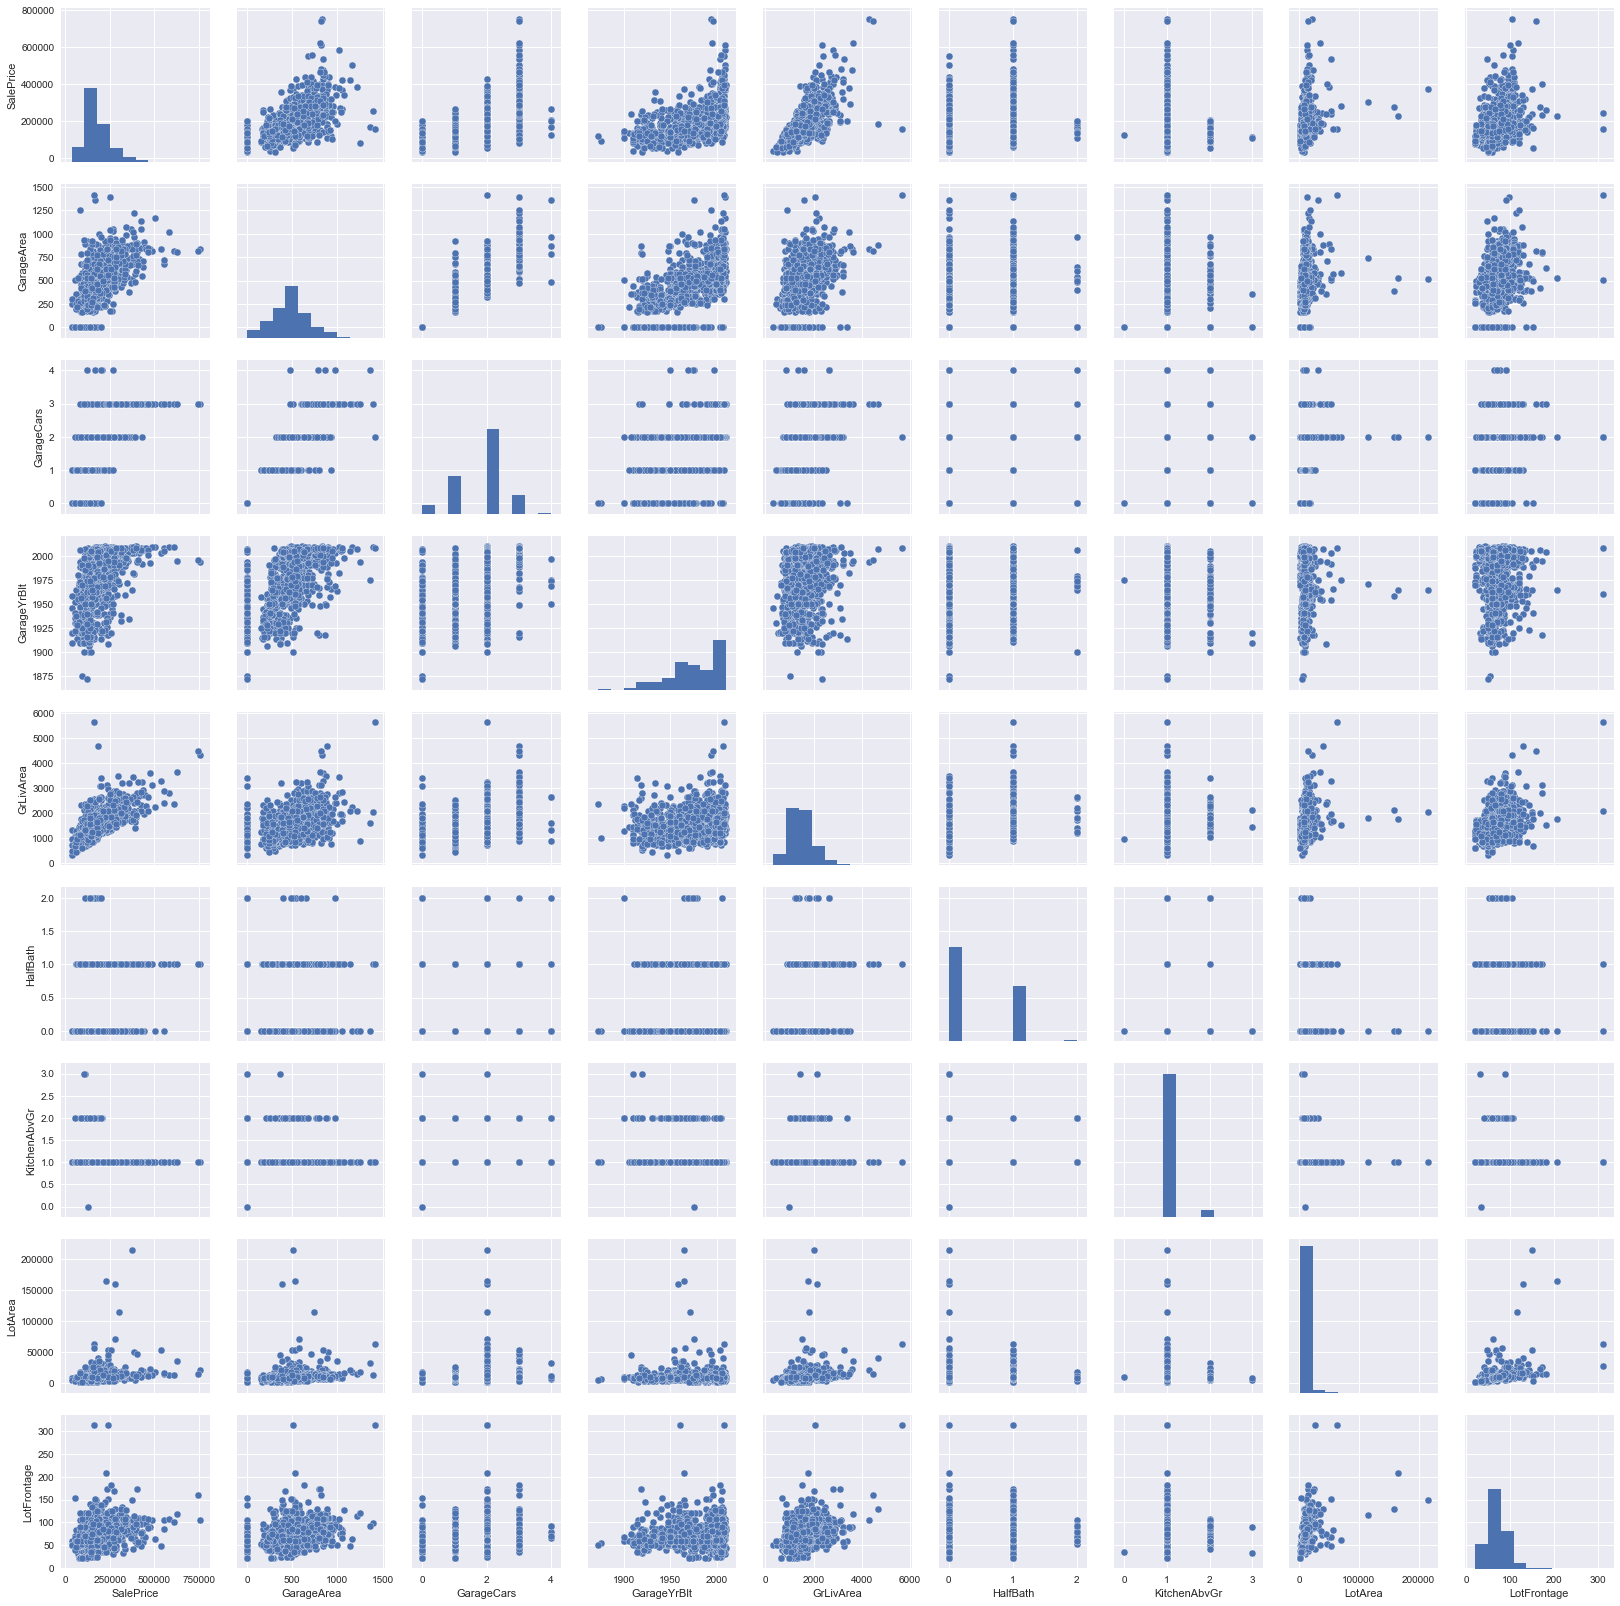

In [105]:
sns.set()
cols = ['SalePrice','GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'KitchenAbvGr',
 'LotArea',
 'LotFrontage']
sns.pairplot(train_data[cols], size = 2.5)
plt.show();



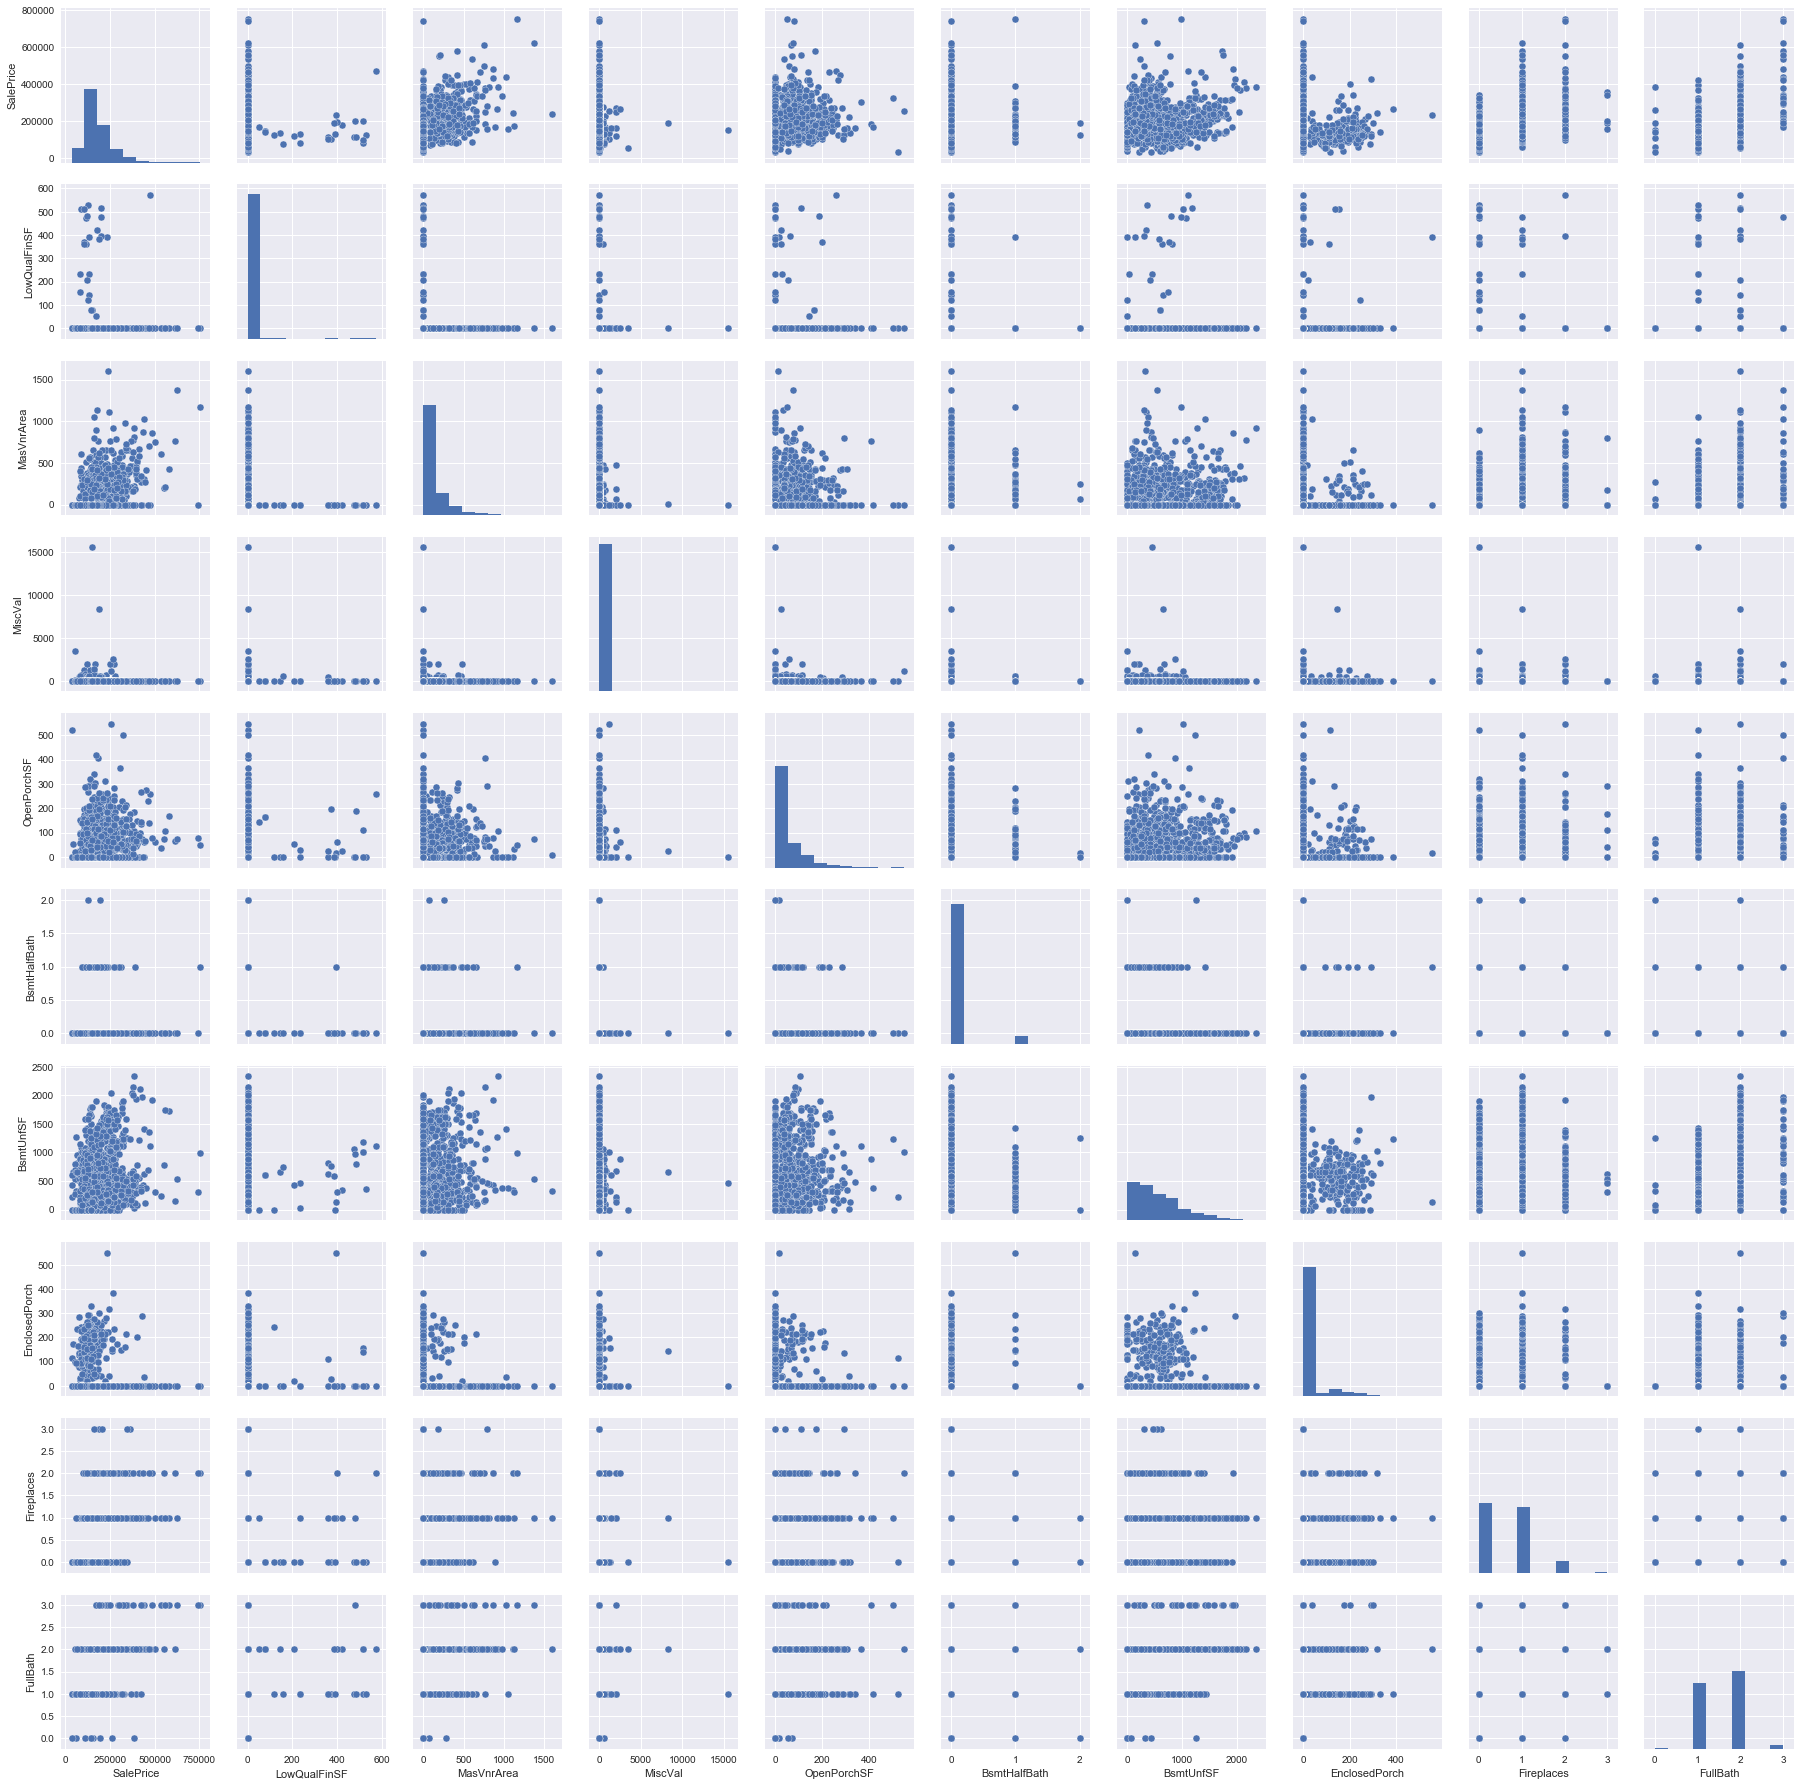

In [106]:
sns.set()
cols = [ 'SalePrice','LowQualFinSF',
 'MasVnrArea',
 'MiscVal',
 'OpenPorchSF','BsmtHalfBath',
 'BsmtUnfSF',
 'EnclosedPorch',
 'Fireplaces',
 'FullBath'
       ]
sns.pairplot(train_data[cols], size = 2.5)
plt.show();

In [107]:
full.FullBath.value_counts()

2    1530
1    1309
3      64
0      12
4       4
Name: FullBath, dtype: int64

In [108]:
#Deleting outliers
train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) 
                                        | (train_data['SalePrice']>600000) 
                                        | (train_data['1stFlrSF']>4000) 
                                        | (train_data['2ndFlrSF']>2000)
                                        | (train_data['3SsnPorch']>400)
                                        | (train_data['BedroomAbvGr']>6)
                                        | (train_data['BsmtFinSF1']>3000)
                                        | (train_data['BsmtFinSF2']>1400)
                                        | (train_data['BsmtFullBath']>2.5)
                                        | (train_data['EnclosedPorch']>500)
                                        | (train_data['TotalBsmtSF']>4500)
                                        | (train_data['WoodDeckSF']>800)
                                        | (train_data['TotRmsAbvGrd']>13)
                                        | (train_data['KitchenAbvGr']>2.5)
                                        | (train_data['LotArea']>100000)
                                        | (train_data['LotFrontage']>225)
                                        | (train_data['MasVnrArea']>1250)
                                        | (train_data['OpenPorchSF']>450)
                                        #| (train_data['BsmtHalfBath']>1.5)
                                        #| (train_data['BsmtUnfSF']>2250)
                                        | (train_data['EnclosedPorch']>400)
                                       ].index)

In [109]:
train_data.shape

(1436, 71)

In [110]:
train_y = train_data['SalePrice']
train_x = train_data.drop(['SalePrice'],axis=1)

### FEATURE ENGINEERING 

In [111]:
#converting years into age 
currentYear = datetime.now().year

In [112]:
train_x['Age_House']=currentYear-train_x['YearBuilt']
train_x['Age_Renovation']=currentYear-train_x['YearRemodAdd']
train_x['Garage_age']=currentYear-train_x['GarageYrBlt']
train_x = train_x.drop(['YearBuilt','YearRemodAdd','GarageYrBlt'],axis=1)

In [113]:
test_x['Age_House']=currentYear-test_x['YearBuilt']
test_x['Age_Renovation']=currentYear-test_x['YearRemodAdd']
test_x['Garage_age']=currentYear-test_x['GarageYrBlt']
test_x = test_x.drop(['YearBuilt','YearRemodAdd','GarageYrBlt'],axis=1)
train_data = pd.concat([train_y, train_x], axis=1)


## EDA

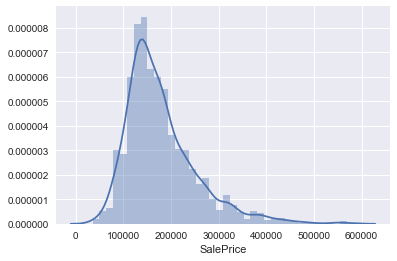

In [114]:
sns.distplot(train_y)

#Deviate from the normal distribution.
#Have appreciable positive skewness.

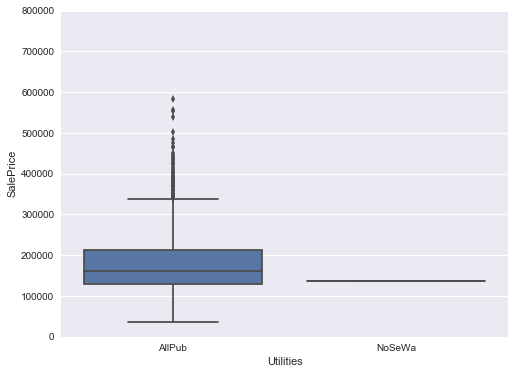

In [115]:
#box plot overallqual/saleprice
var = 'Utilities'
data = pd.concat([train_data['SalePrice'], train_data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

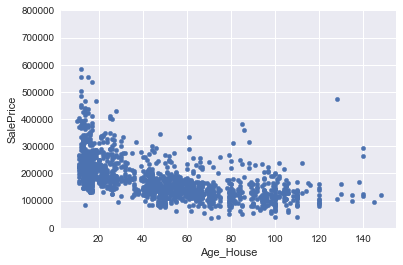

In [116]:
train_data.plot.scatter(x='Age_House', y='SalePrice', ylim=(0,800000))

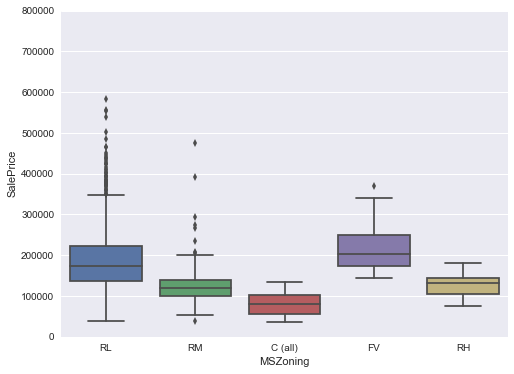

In [117]:
#box plot overallqual/saleprice
var = 'MSZoning'
data = pd.concat([train_data['SalePrice'], train_data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

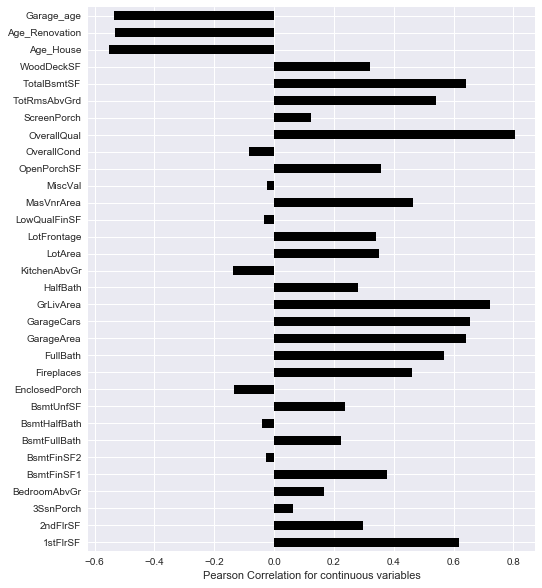

In [118]:
result = pd.concat([train_x, train_y], axis=1)
Corr = result.corr().iloc[:-1,-1]

fig, ax_ = plt.subplots(figsize=(8, 10))
_ =  Corr.plot(kind='barh', ax=ax_, colormap='gnuplot')
_ = ax_.set_xlabel('Pearson Correlation for continuous variables')

In [119]:
train_y.head()

0    208500.0
1    181500.0
2    223500.0
3    140000.0
4    250000.0
Name: SalePrice, dtype: float64

## PREPROCESSING

In [120]:
y_name = 'SalePrice'
x_names = list(train_data.columns.values)
x_names= x_names.remove('SalePrice')

predictors = x_names
response = "SalePrice"

In [121]:
from sklearn.model_selection import train_test_split
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
SEED                    = 1111   # global random seed for better reproducibility

h2o.init(max_mem_size='24G', nthreads=4) # start h2o with plenty of memory and threads
h2o.remove_all()                         # clears h2o memory
h2o.no_progress()                        # turn off h2o progress indicators  

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 35 mins
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.5
H2O_cluster_version_age:,6 days
H2O_cluster_name:,H2O_from_python_vibhz_r14fx0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.16 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [122]:
X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.30, random_state=1111)

In [123]:
X_train = pd.concat([X_train, y_train], axis=1)
X_valid = pd.concat([X_valid, y_valid], axis=1)
X_train_hf = h2o.H2OFrame(X_train)
X_valid_hf = h2o.H2OFrame(X_valid)

## GBM ACTUAL MODEL

In [48]:
# Prepare the hyperparameters
params = {  
                'learn_rate': [0.02,0.03,0.04,0.05,0.06,0.07,0.08], 
                'max_depth': list(range(2,13,2)),
                'ntrees': [20, 50, 80, 110, 140, 170, 200,400,450,500],
                'sample_rate': [0.2,0.3,0.4,0.5,0.8,1], 
                'col_sample_rate': [0.2,0.3,0.4,0.5,0.8,1]
                }


# Prepare the grid object
grid = H2OGridSearch(model=H2OGradientBoostingEstimator,   # Model to be trained
                          grid_id='gbm_grid1',                  # Grid Search ID
                          hyper_params=params,              # Dictionary of parameters
                          search_criteria={"strategy": "Cartesian"}   # RandomDiscrete
                          )

# Train the Model
grid.train(x=predictors,y=response, 
                training_frame=X_train_hf, 
               validation_frame=X_valid_hf,
                score_tree_interval=5,     # For early stopping
                stopping_rounds=3,         # For early stopping
                stopping_tolerance=0.0005,
                seed=1)

H2OJobCancelled: Job<$03017f00000132d4ffffffff$_ac6f774b8bc37e297e63c00b246646ec> was cancelled by the user.

In [ ]:
# Identify the best model generated with least error
sorted_final_grid = grid.get_grid(sort_by='RMSE',decreasing = False)

In [ ]:
##Using the parameters of the trained model on the whole trainig set and getting the model coeff.   

gbm = h2o.get_model(sorted_final_grid.sorted_metric_table()['model_ids'][0])

params = gbm.params
 
gbm_best = H2OGradientBoostingEstimator()

X_train = h2o.H2OFrame(train_data)
gbm_best.train(x=predictors, y=response, training_frame=X_train_hf.rbind(X_valid_hf))       

In [ ]:
preds_valid = gbm_best.predict(X_train_hf.rbind(X_valid_hf))
preds_valid.head(5)





In [ ]:
print(gbm_best.model_performance())

In [ ]:
X_test_hf = h2o.H2OFrame(test_x)
preds = gbm_best.predict(X_test_hf)


In [ ]:
preds = h2o.as_list(preds)
preds.head()

In [ ]:
gbm_best.varimp_plot()

In [ ]:
contributions = gbm_best.predict_contributions(X_test_hf)
contributions.head(5)

In [ ]:
## Saving the model

##  SHAPLEY VALUES

In [ ]:
import shap
shap.initjs()
contributions_matrix = contributions.as_data_frame().as_matrix()

X = list(train_data.columns)
X.remove('SalePrice')
len(X)

In [ ]:
shap_values = contributions_matrix[:,0:68]
expected_value = contributions_matrix[:,68].min()

In [ ]:
shap.force_plot(expected_value, shap_values, X)

The above plot shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red and those pushing the prediction lower are in blue.

Values pushing the model higher than the mean values:
- BsmtFinSF1
- GarageArea 
- LotArea

Values pushing the model lower than the mean values:
- OverallQual
- GrLivArea
- Neighborhood
- GarageCars
- 1stFlrSF

The base value of the median_house_value is 1.809e+5 = 180900

The output value is 125,972.46 based on the first row (X_test_hf[0,:])

In [ ]:
#This can be used to focus on any particulr person and we can get the behaviour of the model for that person. 
shap.force_plot(expected_value, shap_values[0,:], X)

In [ ]:
shap.summary_plot(shap_values, X)

The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value.

The above plot shows the SHAP summary plot. The summary plot combines feature importance with feature effects.

Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value.  Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance.


- Feature importance: Variables are ranked in descending order.
- Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
- Correlation: A high level of the Overall_qual has a high and positive impact on the Overall_qual. The “high” comes from the red color, and the “positive” impact is shown on the X-axis. Similarly, GrLivArea is positively correlated with the target variable median_house_value.

In [ ]:
shap.summary_plot(shap_values, X, plot_type="bar")

## PARTIAL DEPENDENCE

In [ ]:
#For a discrete varaible
#print(best_model.partial_plot(data = X_train_hf, cols = ["MSZoning"], server=True, plot = True))

In [ ]:
for i in Continuous:
    print(gbm_best.partial_plot(data = X_train_hf, cols = [i], server=True, plot = True))

## SURROGATE MODEL

We can use a simpler model to define our model behaviour, here i will use a simple CART decision tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor,tree
dt = DecisionTreeRegressor(max_depth=10, min_samples_leaf=0.04,
random_state=SEED)
preds
test_x_dummies = pd.get_dummies(test_x)

In [ ]:
dt = dt.fit(test_x_dummies,preds)

In [ ]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
feature_cols = list(test_x_dummies.columns.values)

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

## PROFESSOR METHOD 

### SHAPLEY VALUES

In [ ]:
shap_contribs_hf = gbm_best.predict_contributions(X_test_hf)
shap_contribs_matrix = shap_contribs_hf.as_data_frame().values
print(shap_contribs_matrix)
print('\nShapley contributions rows = %d, columns = %d' % (shap_contribs_matrix.shape[0], shap_contribs_matrix.shape[1]))

# ERRORRRRRRR!!! CRAP DON'T USE IT

### CONVERSION TO SUBMISSION FILE

In [ ]:
#pred_pandas.to_csv()
sample_submission = pd.read_csv('./house-prices-data/sample_submission.csv') 
sample_submission['Pred_Saleprice']=preds['predict']
sample_submission = sample_submission.drop(['SalePrice'],axis=1)
sample_submission = sample_submission.rename(columns={"Pred_Saleprice": "SalePrice"})
sample_submission.head()
sample_submission.to_csv('submission.csv',index=False)